In [1]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 
from TraditionalStat import *
from AdvancedStat import * 
from TeamfightDetector import *
from PeriEventTimeHistogram import *

In [13]:
class ScrimLog():
    def __init__(self, csvname=None):
        self.csvname = csvname + '.csv'
        self.match_id = csvname[0:11] # match_id: '(yyyymmdd)_(scrimNum)' (e.g. 20200318_02)
        self.set_directory()
        self.set_df_input()
        self.set_index()
        self.set_WorkshopStat()
        self.set_TraditionalStat()
        self.set_AdvancedStat()
        self.set_TF_Timeline()

    def set_directory(self):
        '''
        Csv file naming convention:     '(yyyy:mm:dd)_(scrimNum)_(enemyTeamName)_(mapName)' e.g. '20210318_02_O2_Oasis'
        MatchId:   '(yyyy:mm:dd)_(scrimNum)' e.g. '20210318_02'
        '''
        path = 'G:/공유 드라이브/NYXL Scrim Log/Csv'
        self.filepath = os.path.join(path, self.csvname)

    def set_df_input(self):
        self.df_input = pd.read_csv(self.filepath)

    def set_index(self):
        # df_init
        self.df_init = self.df_input 
        
        # match_id
        self.df_init['MatchId'] = self.match_id

        # team name
        NYE_alt_names = ['NYXL', 'Team 1', '1팀', 'New York Excelsior', 'New York']
        team_one_name = self.df_init['Team'].unique()[0]
        team_two_name = self.df_init['Team'].unique()[1]

        if team_one_name == 'NYE':
            pass
        elif team_one_name in NYE_alt_names:
            self.df_init['Team'] = self.df_init['Team'].replace({team_one_name:'NYE'})
            team_one_name = 'NYE'
        elif team_two_name == 'NYE':
            team_one_name = self.df_init['Team'].unique()[1]
            team_two_name = self.df_init['Team'].unique()[0]
        elif team_two_name in NYE_alt_names:
            self.df_init['Team'] = self.df_init['Team'].replace({team_two_name:'NYE'})
            team_one_name = self.df_init['Team'].unique()[1]
            team_two_name = 'NYE'
        else:
            raise Exception('NYE is not designated as Team 1. Check the Team names')
        
        self.team_one_name = team_one_name
        self.team_two_name = team_two_name

        # idx_col
        self.idx_col = ['MatchId', 'Map', 'Section', 'Timestamp', 'Team', 'RoundName', 'Point', 'Player', 'Hero']
    
    def set_WorkshopStat(self):
        df_WorkshopStat = self.df_init.groupby(self.idx_col).sum()

        self.df_WorkshopStat = df_WorkshopStat
    
    def set_TraditionalStat(self):

        # TimePlayed        
        df_TraditionalStat = TimePlayed(self.df_WorkshopStat).get_df_result()
        # AllDamageDealt
        df_TraditionalStat = AllDamageDealt(df_TraditionalStat).get_df_result()
        # Cooldown1Percent
        df_TraditionalStat = Cooldown1Percent(df_TraditionalStat).get_df_result()
        # Cooldown2Percent
        df_TraditionalStat = Cooldown2Percent(df_TraditionalStat).get_df_result()
        # CooldownSecondaryFirePercent
        df_TraditionalStat = CooldownSecondaryFirePercent(df_TraditionalStat).get_df_result()
        # CooldownCrouchingPercent
        df_TraditionalStat = CooldownCrouchingPercent(df_TraditionalStat).get_df_result()
        # HealthPercent
        df_TraditionalStat = HealthPercent(df_TraditionalStat).get_df_result() # Health column 추가되면 진행
        # NumAlive
        df_TraditionalStat = NumAlive(df_TraditionalStat).get_df_result()

        # dx
        '''
        현재 스크림 워크샵이 영웅별로 스탯을 누적해주는 것이 아니라 플레이어 별로 스탯을 누적해주기 때문에 선수가 도중에 영웅을 바꿀 경우 diff() 함수에서 문제가 발생 --> `hero_col` 따로 빼서 diff() 구하고 나중에 merge로 해결
        '''
        def diff_stat(df_input=None):
            diff_stat_list = [] # define stat names to diff()
            df_init = df_input.reset_index()
            # grouping = [x for x in self.idx_col if x != 'Hero']
            grouping = [x for x in self.idx_col if x not in ['Hero', 'Point']]
            hero_col = df_init.set_index(grouping)['Hero']
            df_group = df_init.groupby(by=grouping).sum()
            dx = df_group.groupby([x for x in grouping if x != 'Timestamp']).diff().fillna(0)
            df_merge = pd.merge(df_group, dx, how='outer', left_index=True, right_index=True, suffixes=('', '/s'))
            df_merge = pd.merge(df_merge, hero_col, how='outer', left_index=True, right_index=True) # add hero_col

            return df_merge
        
        # calculate dx table and merge
        df_TraditionalStat = diff_stat(df_input=df_TraditionalStat)

        # indexing
        df_TraditionalStat = df_TraditionalStat.groupby(by=self.idx_col).sum()

        self.df_TraditionalStat = df_TraditionalStat

    def set_AdvancedStat(self):
        # RCP
        df_AdvancedStat = RCPv1(self.df_TraditionalStat).get_df_result()
        # FB_value
        df_AdvancedStat = FBValue(df_AdvancedStat).get_df_result()
        # Death_risk
        df_AdvancedStat = DeathRisk(df_AdvancedStat).get_df_result()

        # indexing
        df_AdvancedStat = df_AdvancedStat.groupby(by=self.idx_col).sum()

        self.df_AdvancedStat = df_AdvancedStat
    
    def set_TF_Timeline(self):
        df_FinalStat = TeamfightDetector(self.df_AdvancedStat).get_df_result()
        
        self.df_FinalStat = df_FinalStat


        # reset index and grouping
        def indexing(df):
            df = df.reset_index()
            df = df.groupby(by=self.idx_col).max()
            return df 
        
        self.df_FinalStat = indexing(self.df_FinalStat)

    
    def get_df_FinalStat(self):
        return self.df_FinalStat
    
    def get_TF_info(self):
        return self.TF_info

    def export_to_csv(self, save_dir='G:/공유 드라이브/NYXL Scrim Log/FinalStat'):
        self.df_FinalStat.to_csv(os.path.join(save_dir, f'FinalStat_{scrim.csvname}'))


In [14]:
filename = '20210325_02_TAL_Busan'
scrim = ScrimLog(filename)
scrim.export_to_csv()

d:\owl-data\Project\project 5_scrim stat log\TraditionalStat.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_level_col['new_col'] = stat_level_col['HeroDamageDealt'] + stat_level_col['BarrierDamageDealt']
C:\Users\jyc13\anaconda3\envs\owl-data\lib\site-packages\pandas\core\frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
d:\owl-data\Project\project 5_scrim stat log\TraditionalStat.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

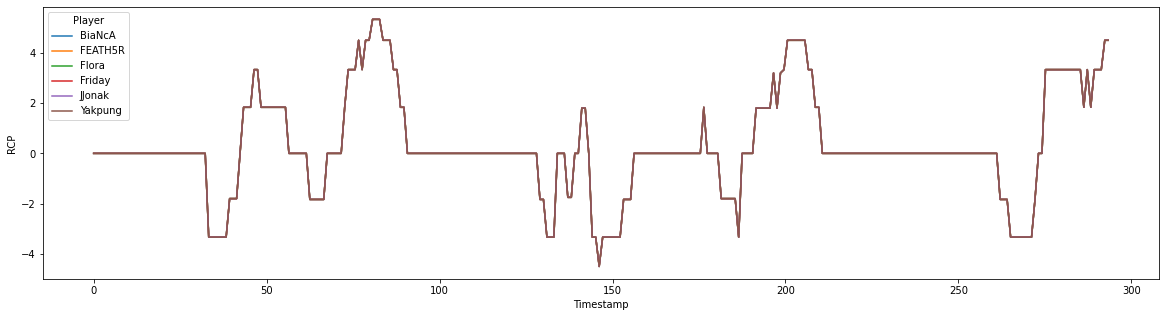

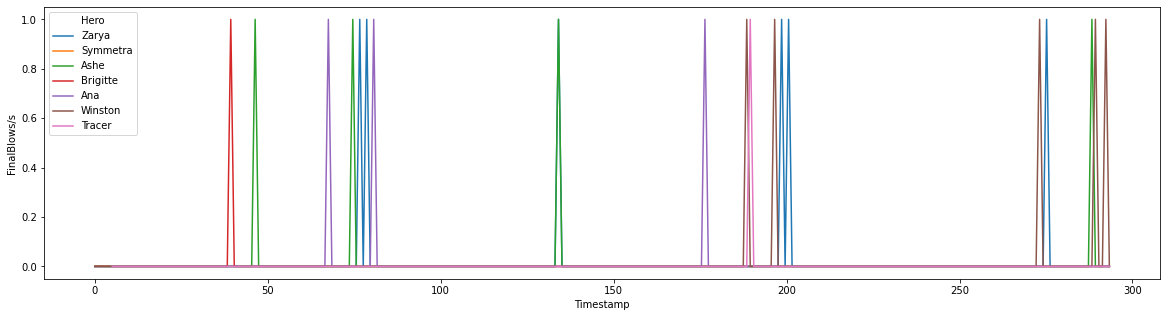

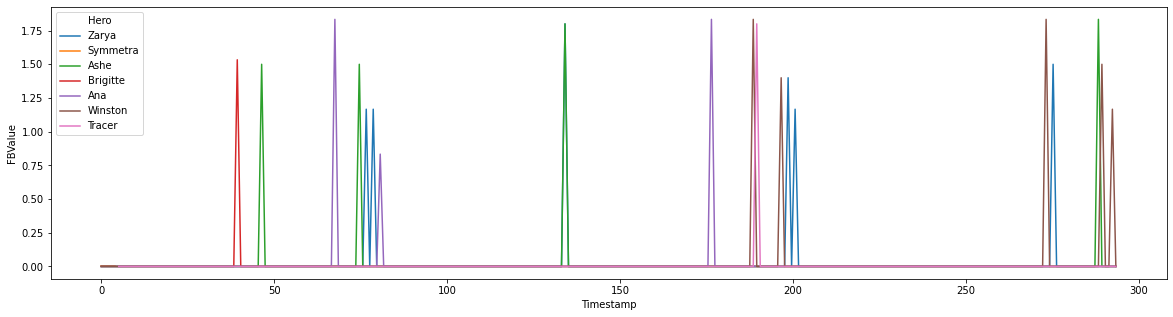

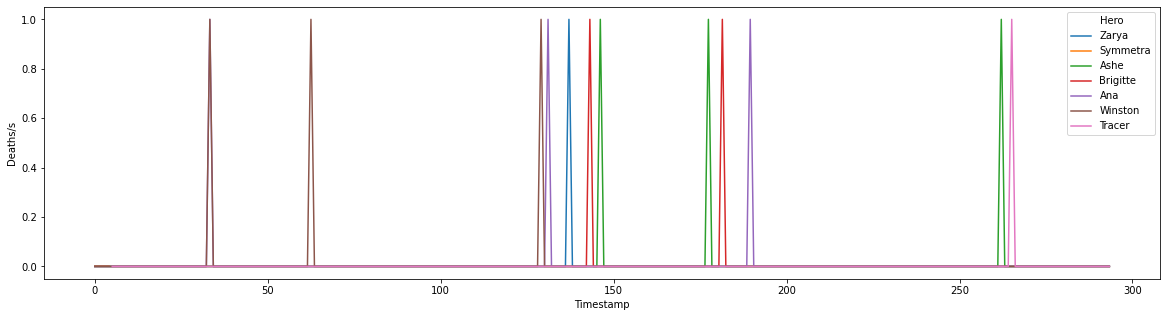

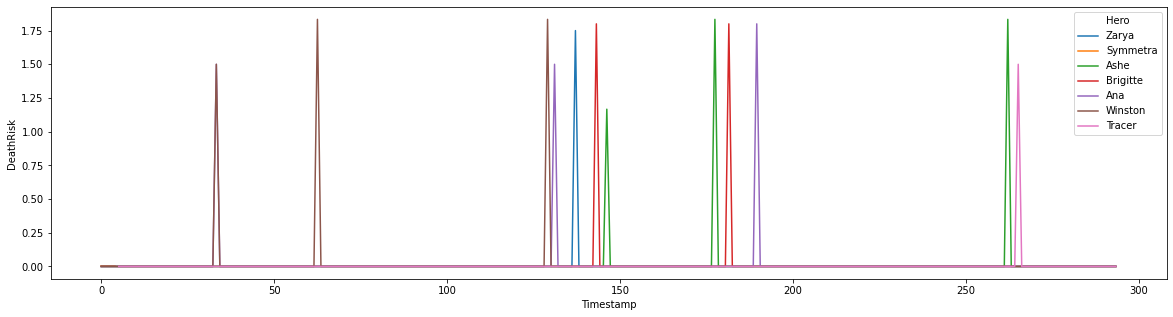

In [4]:
plt.figure(figsize=(20,5))
sns.lineplot(x='Timestamp', y='RCP', data=df_AdvancedStat.xs((0, 'NYE'), level=['Section', 'Team']), hue='Player')
plt.show()
plt.figure(figsize=(20,5))
sns.lineplot(x='Timestamp', y='FinalBlows/s', data=df_TraditionalStat.xs((0, 'NYE'), level=['Section', 'Team']), hue='Hero')
plt.show()
plt.figure(figsize=(20,5))
sns.lineplot(x='Timestamp', y='FBValue', data=df_AdvancedStat.xs((0, 'NYE'), level=['Section', 'Team']), hue='Hero')
plt.show()
plt.figure(figsize=(20,5))
sns.lineplot(x='Timestamp', y='Deaths/s', data=df_TraditionalStat.xs((0, 'NYE'), level=['Section', 'Team']), hue='Hero')
plt.show()
plt.figure(figsize=(20,5))
sns.lineplot(x='Timestamp', y='DeathRisk', data=df_AdvancedStat.xs((0, 'NYE'), level=['Section', 'Team']), hue='Hero')
plt.show()

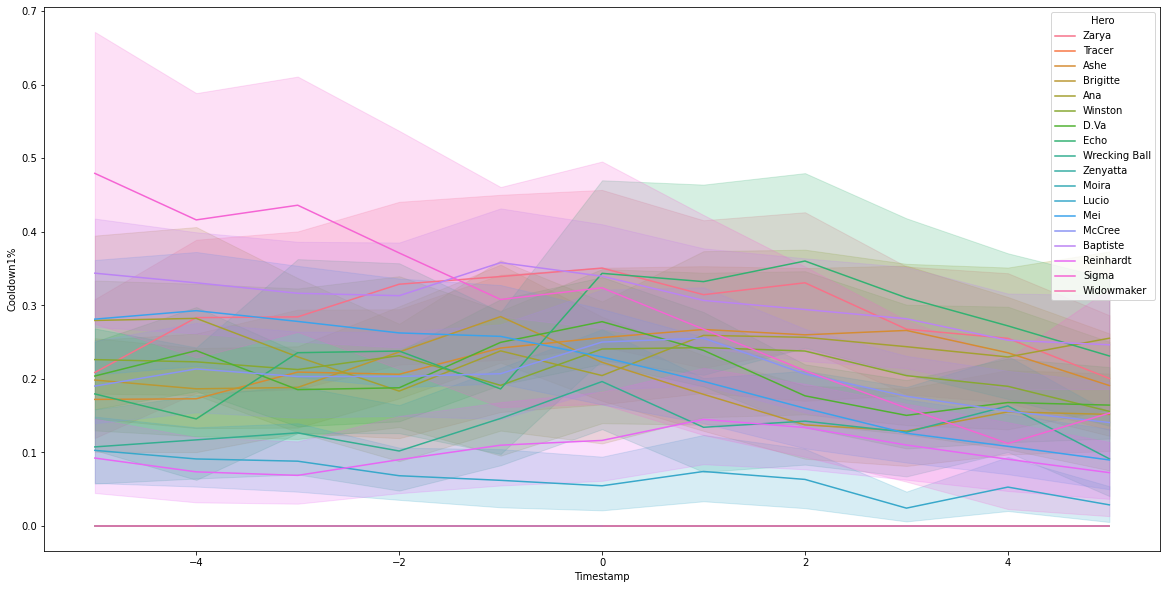

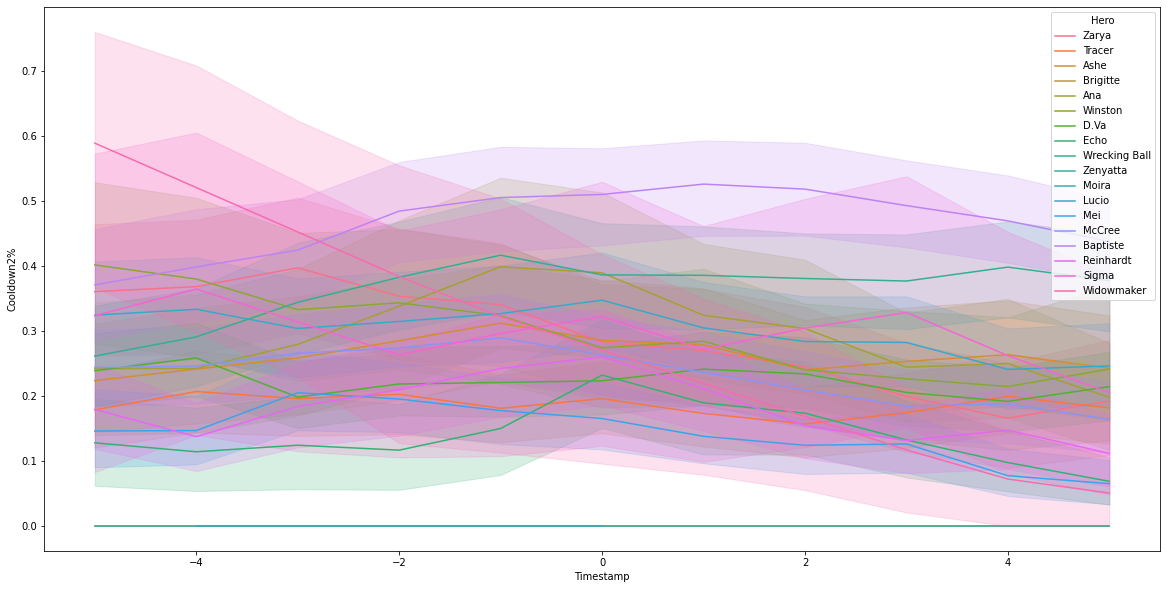

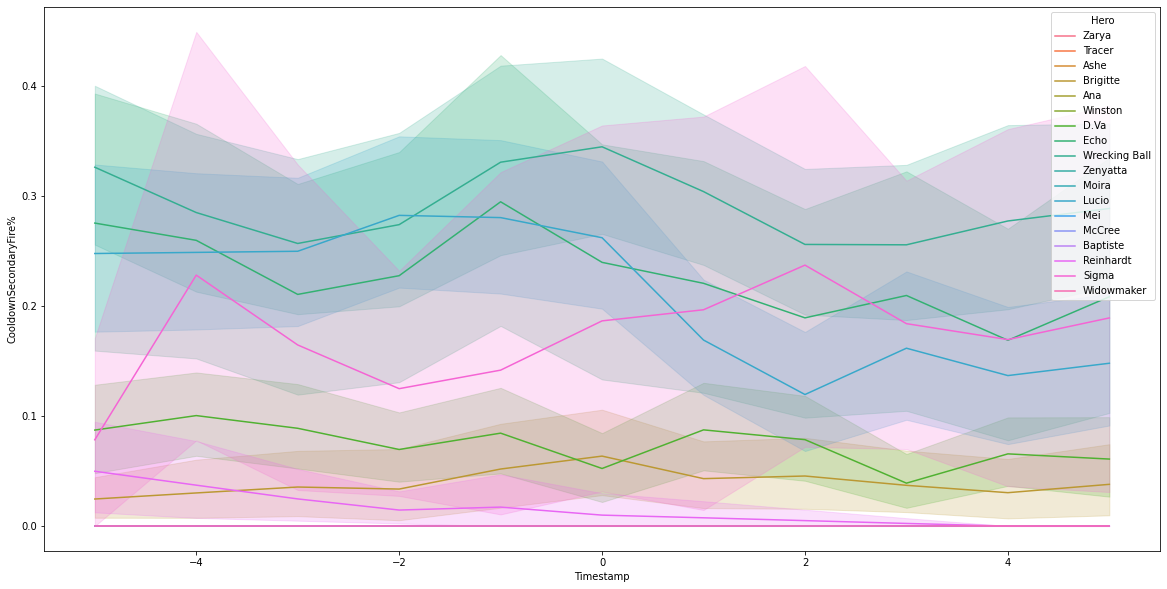

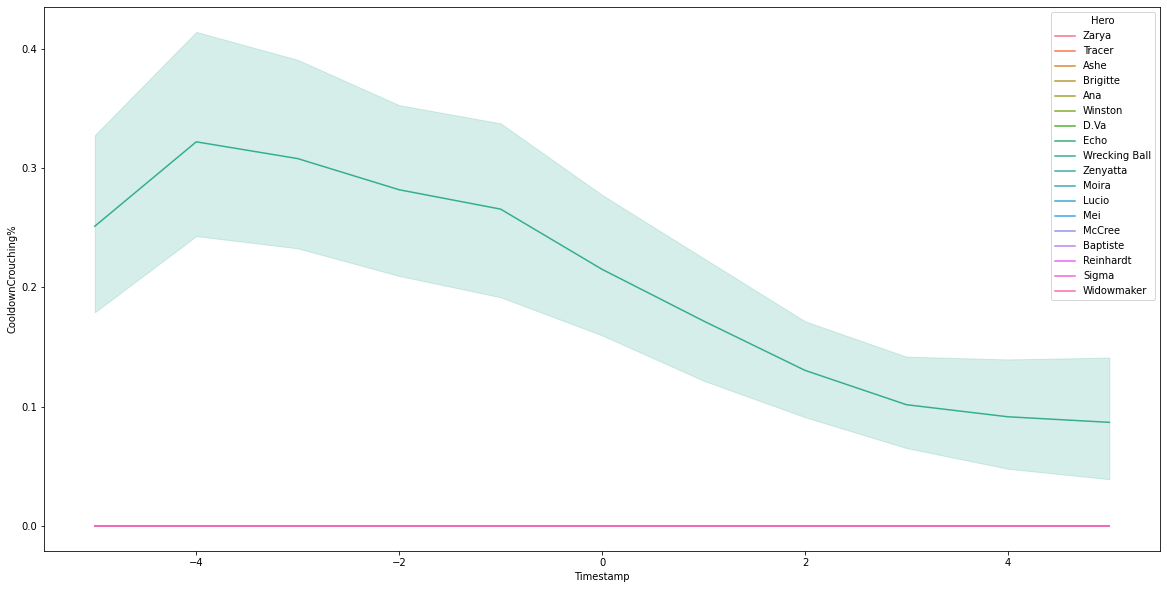

In [10]:
df_peth_FB = PETH(df_init=df_FinalStat, event_name='FinalBlows/s', period=5)
df_peth_FB = df_peth_FB.get_PETH(of='Tracer').groupby(by=['MatchId', 'Map', 'Section', 'num_event', 'Timestamp', 'Team', 'Player', 'Hero']).sum()

plt.figure(figsize=(20, 10))
sns.lineplot(x='Timestamp', y='Cooldown1%', data=df_peth_FB, hue='Hero')
plt.show()

plt.figure(figsize=(20, 10))
sns.lineplot(x='Timestamp', y='Cooldown2%', data=df_peth_FB, hue='Hero')
plt.show()

plt.figure(figsize=(20, 10))
sns.lineplot(x='Timestamp', y='CooldownSecondaryFire%', data=df_peth_FB, hue='Hero')
plt.show()

plt.figure(figsize=(20, 10))
sns.lineplot(x='Timestamp', y='CooldownCrouching%', data=df_peth_FB, hue='Hero')
plt.show()

In [7]:
'''
PETH 개념을 거꾸로 가져가서 몇 가지 event가 동시에 or interval 이내에 일어났을 때를 기준으로 (t=0) 'deaths/s', 'final blows/s' 등의 event 확률 histogram 보여주는 기능 추가
'''

"\nPETH 개념을 거꾸로 가져가서 몇 가지 event가 동시에 or interval 이내에 일어났을 때를 기준으로 (t=0) 'deaths/s', 'final blows/s' 등의 event 확률 histogram 보여주는 기능 추가\n"